# CLASSIFICATION-- CUSTOMER CHURN PREDICTION 

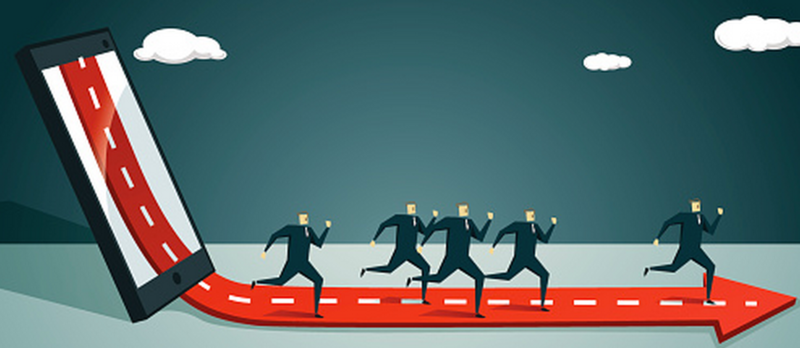

# Introduction (What is Customer Churn?)

Customer churn is when customers or subscribers discontinue doing business with a firm or service.

To be simple, it is when customers stops being your customer.

Telco churn data includes information about a fictitious telecom company that provided home phone and Internet services to 7,043 California customers in the third quarter. Which customers have left, stayed, or signed up for their service shows?

In this project, we aim to find the likelihood of a customer leaving the organization, the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

# Installation

In [1]:
# !pip install xgboost

# Importation

In [2]:
# Data handling
import pandas as pd
import numpy as np
import threadpoolctl
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from collections import Counter

# balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
data = pd.read_csv('Fraud.csv')

# Exploratory Data Analysis

## Hypothesis

H0: The sample has a Gaussian distribution in the numerical feautures.

H1: The sample does not have a Gaussian distribution in the numerical feautures.

## Questions

1. Does longer tenure increase churn?
2. Is there any pattern in Customer Churn based on gender?
3. Which type of contract keeps more customers?
4. What's the most profitable Internetservice type?

## Issues with the data

1. Some of the columns are irrelevant.
2. some of the columns are not in their respective data types.
3. The data values in the column payments method needs is not good for readability.
4. The data has missing values

## How I Intend to Solve Them

1. Drop irrelevant columns
2. Replace the correct data types in their respective columns
3. Rename the data values for better readability.


Rename the columns for better readability.

In [4]:
data.rename(columns={
    'step': 'time_step',
    'type': 'trans_type',
    'amount': 'trans_amt',
    'nameOrig': 'cust_orig',
    'oldbalanceOrg': 'old_orig_bal',
    'newbalanceOrig': 'new_orig_bal',
    'nameDest': 'cust_dest',
    'oldbalanceDest': 'old_dest_bal',
    'newbalanceDest': 'new_dest_bal'
}, inplace=True)

In [5]:
data.head()

,time_step,trans_type,trans_amt,cust_orig,old_orig_bal,new_orig_bal,cust_dest,old_dest_bal,new_dest_bal,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
data['isMerchant'] = data['cust_dest'].apply(lambda x: 1 if x.startswith('M') else 0)

In [7]:
data.shape

(6362620, 12)

In [8]:
# summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time_step       int64  
 1   trans_type      object 
 2   trans_amt       float64
 3   cust_orig       object 
 4   old_orig_bal    float64
 5   new_orig_bal    float64
 6   cust_dest       object 
 7   old_dest_bal    float64
 8   new_dest_bal    float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  isMerchant      int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 582.5+ MB


In [9]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, data[col].nunique())

trans_type 5
cust_orig 6353307
cust_dest 2722362


cust_orig and cust_dest are unique for each transaction, so we can drop them.

In [10]:
data.drop(columns=['cust_orig', 'cust_dest'], inplace=True)

In [11]:
data.describe()

,time_step,trans_amt,old_orig_bal,new_orig_bal,old_dest_bal,new_dest_bal,isFraud,isFlaggedFraud,isMerchant
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,3.381461e-01
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,4.730786e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00


check for outliers only in the columns that shouldn't have outliers

In [12]:
# Check of outliers by applying the IQR method checking
df = data.drop(['trans_type', 'time_step', 'isFraud', 'isFlaggedFraud', 'isMerchant'], axis=1)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
IQR
((df < (Q1-1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any()


trans_amt       True
old_orig_bal    True
new_orig_bal    True
old_dest_bal    True
new_dest_bal    True
dtype: bool

The results above showed there are outliers, but these outliers are probably because of fraudulent transactions

## Bivariate Analysis

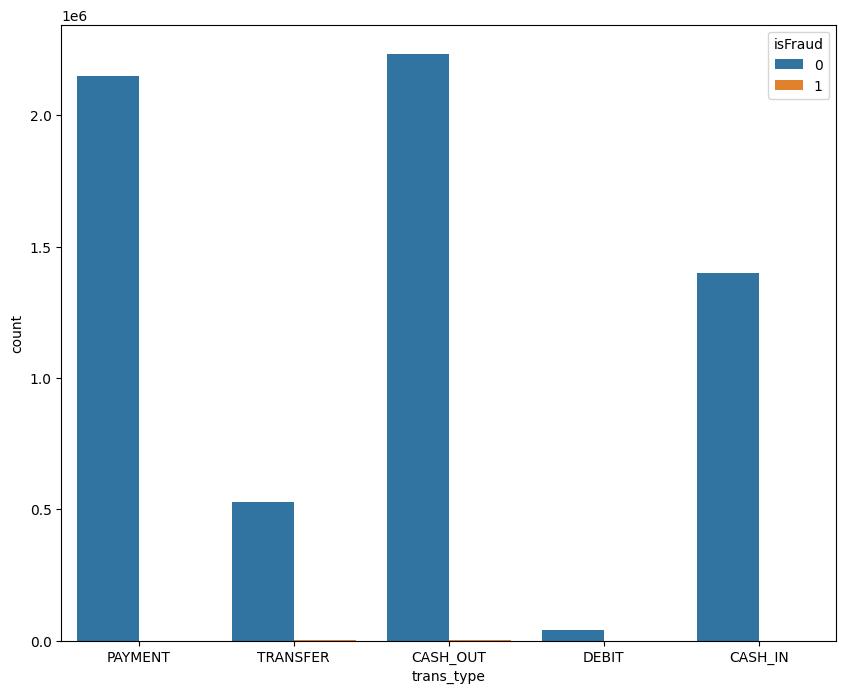

In [17]:
fig = plt.figure(figsize= (10,8))

sns.countplot(data = data, 
              x = 'trans_type', 
              hue = 'isFraud')
plt.show()

let's see for other categories

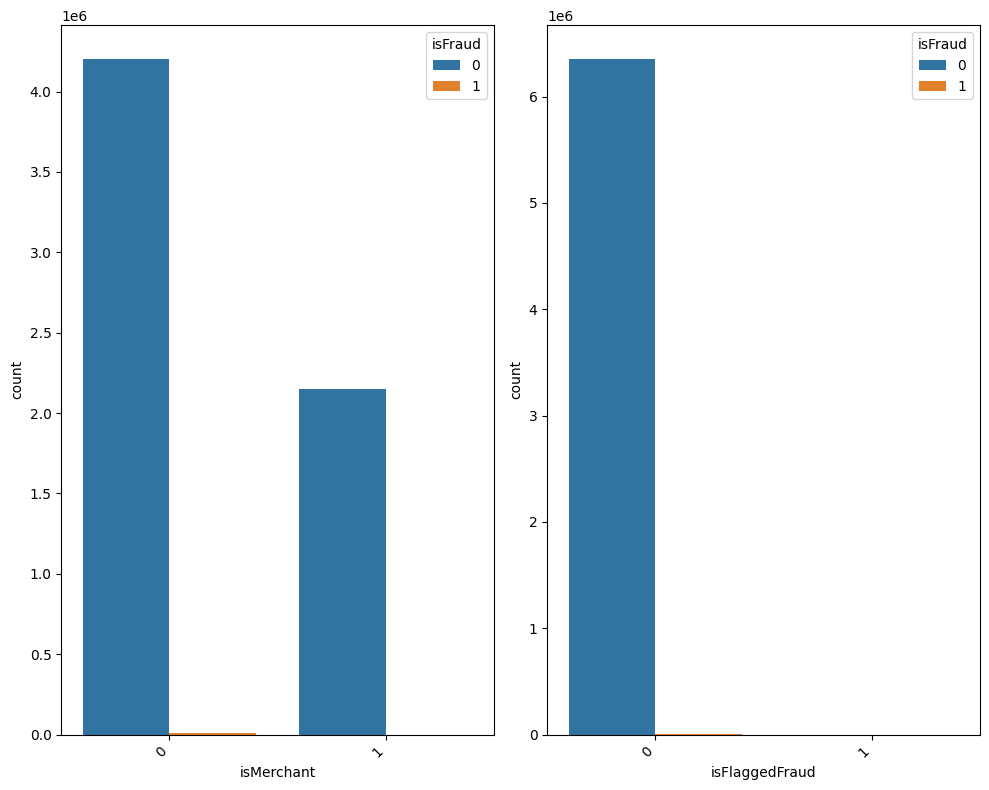

In [16]:
# Setup figure
cols = 2
rows = 1
fig = plt.figure(figsize= (10,8))

# Plotting
for i, col in enumerate(['isMerchant', 'isFlaggedFraud']):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=data[col], hue='isFraud', data=data, ax=ax)    
    plt.xticks(rotation=45, ha='right')
fig.tight_layout()  
plt.show()

In [19]:
fig = plt.figure(figsize= (10,8))
sns.histplot(data=data,
            x='trans_amt',
            hue='isFraud', alpha=0.5)
fig.tight_layout()  
plt.show()

## Multivariate Analysis

In [ ]:
m

In [ ]:
# Setup figure
cols = 5
rows = 5
fig, axes = plt.subplots(rows, cols, figsize=(30, 30))

# Iterate over each column
for i, column in enumerate(numeric):
    # Plot histogram for the current column
    sns.histplot(data=data, x=column, hue='Disease', alpha=0.5, ax=axes[i])
    axes[i].set_title(column)  # Set title for the subplot
plt.tight_layout()
plt.show()

It seems that white blood cell count and Alanine Aminotransferase (U/L) 
have little or no effect on disease possibility

In [ ]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
categoric = [col for col in data.columns if data[col].dtype == 'object']

In [ ]:
# correlation heatmap df
correlation = data[numeric].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

In [ ]:
# correlation heatmap df
correlation = data[numeric].corr()

# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", pair[2])
else:
    print("No high correlation columns")

In [ ]:
sns.pairplot(data,vars = ['old_orig_bal','new_orig_bal','old_dest_bal', 'new_dest_bal'], hue="isFraud")

these variables have a very high correlation

In [ ]:
# so we will drop one from each pair
# data.drop(columns=['old_orig_bal', 'old_dest_bal'], inplace=True)

In [ ]:
color = ('#40DFEF', '#E78EA9')
fig, ax = plt.subplots(1, 3, figsize=(20,8))
for i, p in numeric:
        sns.boxplot(data=data, x='Churn', y=p, ax=ax[i], palette= color)
        ax[i].set_title(p)

## Hypothesis validation

## Statistical Normality Tests

Normality tests are used to determine if a dataset is normally distributed about the mean value. it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.

on the other hand, Gaussian distribution is a continuous probability distribution with symmetrical sides around its center. Its mean, median and mode are equal.

Popular normality tests - D’Agostino’s K^2, Shapiro-Wilk, Anderson-Darling .

### D’Agostino’s K^2 Test

In [ ]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
for col in data[numeric]:
    stat, p = stats.normaltest(data[col])
    # print('Statistics=%.5f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'looks Gaussian (fail to reject H0) for this column: {col}')
    else:
        print(f'does not look Gaussian (reject H0) for this column: {col}')


## Anwering Questions

## 1. Does longer tenure increase churn?
customers with longer tenure have less churn rate.

In [ ]:
# sns.pairplot(data,vars = ['tenure','MonthlyCharges'], hue="Churn")

## 2. Is there any pattern in Customer Churn based on gender?
The plot below shows that churn for both genders is very similar.

In [ ]:
# sns.countplot(data = data, 
#               x = 'gender', 
#               hue = 'Churn')
# plt.show()

## 3. Which type of contract keeps more customers?
Churn rate for month-to-month contracts much higher that for other contract durations.

In [ ]:
# sns.countplot(data = data, 
#               x = 'Contract', 
#               hue = 'Churn')
# plt.show()

## 4. What's the most profitable Internetservice type
FiberOptic InternetService keeps more customers

In [ ]:
# sns.countplot(data = data, 
#               x = 'InternetService', 
#               hue = 'Churn')
# plt.show()

# Feature Processing & Engineering

## Drop Duplicates

In [ ]:
data.shape

In [ ]:
data.duplicated().sum()

let's have a closer look at the duplicates

In [ ]:
data['trans_type'].unique()

In [ ]:
dup = data.loc[data.duplicated(),:]
dup.head(22)

these transactions look fraudulent, 

money was payed, but there is no trace of it in either sending or receiving accounts

so we'll leave them

those do not look like duplicates, so we'll ignore

## Creating new features

Most features turned out to have no effect 
on the performance of our best performing model

so we will drop those features as they will not affect our f2 score

In [ ]:
# columns_to_keep = [
#     'Mean Corpuscular Hemoglobin (pg)',
#     'Mean Corpuscular Volume (fL)',
#     'Hematocrit (%)',
#     'White Blood Cell Count (10^3/µL)',
#     'Cholesterol Level (mg/dL)',
#     'Platelet Count (10^9/L)',
#     'White Blood Cell Count (10^3/µL)',
#     'Glucose',
#     'Disease'
# ]

# columns_to_drop = [col for col in data.columns if col not in columns_to_keep]
# data.drop(columns=columns_to_drop, inplace=True, axis=1)
# test.drop(columns=columns_to_drop, inplace=True, axis=1)


## Impute Missing Values

In [ ]:
data.isnull().sum()

In [ ]:
# Drop the missing rows
# data = data.dropna()

In [ ]:
df = data
X = df.drop('isFraud', axis=1)
y = df['isFraud']

## Data Imbalance Check

In [ ]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

l1 = list(data['isFraud'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['No Fraud','isFraud'], 
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('isFraud and No Fraud %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data, 
                   x='isFraud',
                   palette = palette, 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['No Fraud','isFraud'])
    
plt.title('isFraud and No Fraud')
plt.show()


Dataset is imbalanced.

This means that a blind guess (on "No Fraud") would give us accuracy of 99%

Therefore, we can't use Accuracy Score to choose our model

what to do to solve this issue:

1. We could use stratified splitting during train-test split (split the dataset in a way that preserves the same proportions of examples in each class.)
2. We could be extra careful when dealing with outliers (we can delete meaningull information).
3. Resampling Techniques — Oversample minority class or Undersample majority class.

In [ ]:
#Oversampling the minority class (the churn customers)
ros = RandomOverSampler(random_state=0)
# X_new,y_new= ros.fit_resample(X, y)
X_new,y_new= X, y

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

Now our data is balanced

# Dataset Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.20, random_state = 42)

In [ ]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

# Features Encoding

In [ ]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
print("numeric_cols:", numeric)
print("categoric_cols:", categoric)
categoric = [col for col in data.columns if data[col].dtype == 'object']

In [ ]:
# calling our encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop="first")
# setting output to DataFrame
encoder.set_output(transform="pandas")
# encoding our data
X_catEncoded_train = encoder.fit_transform(X_train[categoric])
X_catEncoded_test = encoder.transform(X_test[categoric]) # encoding our test data

# Features Scaling


In [ ]:
Scaler = StandardScaler().fit(X_train[numeric]).set_output(transform="pandas")

X_numScaled_train = Scaler.transform(X_train[numeric])
X_numScaled_test = Scaler.transform(X_test[numeric])

In [ ]:
X_train = pd.concat([X_numScaled_train, X_catEncoded_train], axis=1)
X_test = pd.concat([X_numScaled_test, X_catEncoded_test], axis=1)

# Machine Learning Modeling


## 1.  Logistic Regression

### Create the Model

In [ ]:
model= LogisticRegression()

### Train the Model

In [ ]:
model=model.fit(X_train, y_train)


###  Predict on the test dataset

In [ ]:
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]


### Model Evaluation

In [ ]:
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)
     

In [ ]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

## 3. XGBoost Classifier

### Create the Model

In [ ]:
XG_model= XGBClassifier()

### Train the Model

In [ ]:
XG_model= XG_model.fit(X_train, y_train)

### Predict on the test dataset

In [ ]:
XG_pred = XG_model.predict(X_test)
XG_prob = XG_model.predict_proba(X_test)[:,1]

### Model Evaluation

In [ ]:
r_XG= recall_score(y_test, XG_pred)
print("recall_score : ", r_XG)

p_XG= precision_score(y_test, XG_pred)
print("precision_score :",p_XG)

f1_XG= f1_score(y_test, XG_pred)
print("f1_score :", f1_XG)

f2_XG = fbeta_score(y_test, XG_pred, beta=2, average='binary')
print("f2_score :", f2_XG)


A_XG= accuracy_score( y_test, XG_pred)
print("accuracy_score :",A_XG)

acu_XG = roc_auc_score(XG_pred, y_test)
print("ROC_AUC Score:",acu_XG)
     

In [ ]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, XG_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('XGBoost ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

##  6. DecisionTreeClassifier

### Create the Model

In [ ]:
dtmodel = DecisionTreeClassifier()

### Train the Model

In [ ]:
dtmodel = dtmodel.fit(X_train, y_train)

### Predict on the test dataset

In [ ]:
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

### Model Evaluation

In [ ]:
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

# Models comparison

False Negatives:

False negatives occur when the model incorrectly predicts that a patient does not have the disease when, in reality, they do.
The consequence of a false negative is that the patient may not receive necessary treatment or intervention, potentially leading to undetected or untreated health issues. This can result in the progression of the disease, worsening health outcomes, and possibly even life-threatening situations if the disease is serious.

Given that false negatives are more costly in this medical diagnosis classification project, and I've balanced the classes using Random Over Sampler, it's advisable to prioritize metrics that focus on minimizing false negatives.

In this context, the most appropriate metric to use would be recall or the F2 score. Both of these metrics emphasize the minimization of false negatives, making them suitable for scenarios where the cost of missing positive cases (i.e., false negatives) is high.

In [ ]:
compare_models = ['Logistic Regression', 'XGBClassifier', 'DecisionTreeClassifier']

data = {
    'Accuracy': [A_lgt, A_XG, A_dt],
    'Recall': [r_lgt, r_XG, r_dt],
    'Precision': [p_lgt, p_XG, p_dt],
    'f1_score': [f1_lgt, f1_XG, f1_dt],
    'f2_score': [f2_lgt, f2_XG, f2_dt],
    'ROC_AUC': [acu_lgt, acu_XG, acu_dt],
    'Description': ['', 'best model', '']
}
result=pd.DataFrame(data=data, index=compare_models)
result

In a fraud detection project, it is generally more important to prioritize false negatives over false positives. This is because false negatives mean that fraudulent transactions go undetected, leading to potential financial losses and other negative consequences. False positives, while inconvenient, do not result in direct financial loss and can be managed with additional verification steps.

Given this context, the best metrics to focus on are Recall and f2_score. Recall measures the ability to identify actual fraud cases correctly (minimizing false negatives), while the f2_score places more emphasis on recall compared to precision.


Based on the above metrics, **XGBClassifier is the best model** for this fraud detection project as it has the highest recall (0.870370) and a high f2_score (0.886346), indicating it is effective in detecting fraudulent transactions while minimizing false negatives.

In the context of fraud detection, ROC_AUC is important because it gives a holistic view of the model's performance across all classification thresholds. 

Based on the ROC_AUC values and previously discussed metrics (recall and f2_score), XGBClassifier stands out as the best model for this fraud detection project with the highest ROC_AUC (0.978208).

# k-Fold cross validation 

## XGBoost Classifier (Best Model)

In [ ]:
xgb_dt = KFold(n_splits = 5,shuffle=True)
# Define custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

score = cross_val_score(XG_model, X_train, y_train, cv=xgb_dt, scoring=f2_scorer, error_score="raise")
xgb_cv_score = score.mean()
xgb_cv_stdev = stdev(score)
print('Cross Validation f2 scores are: {}'.format(score))
print('Average Cross Validation f2 score: ', xgb_cv_score)
print('Cross Validation f2 standard deviation: ', xgb_cv_stdev)

# Model Improvement

# Hyperparameters tuning

## DecisionTreeClassifier

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7, 10],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'gamma': [0, 0.1, 0.3, 0.5],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [0.1, 1, 10]  # L2 regularization term on weights
}

In [ ]:
# make GridSearchCV object
xgb_Grid = GridSearchCV(estimator = XG_model, 
                       param_grid = param_grid_xgb, 
                       cv = 4, 
                       verbose = 2 , 
                       n_jobs = -1, 
                       scoring=f2_scorer,
                       refit=True)

In [ ]:
# Fit the GridSearchCV object to the data
xgb_Grid.fit(X_train,y_train)

In [ ]:
# Get the best estimator and its score
xgb_tuned = xgb_Grid.best_estimator_
xgb_Grid.best_score_

In [ ]:
# Use the best estimator for predictions
y_pred_grid = xgb_tuned.predict(X_test)
f2_xgb = fbeta_score(y_test, y_pred_grid, beta=2, average='binary')
print("f2_score :", f2_xgb)

In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(xgb_tuned, f)

# Using Confusion Matrix For Predictions

# DecisionTree Classifier

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
y_pred_xgb = xgb_Grid.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb_Grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_Grid.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:

1. We successfully predicted 416 patients with no disease and 5 with disease
2. There are 65 patients who are predicted to have disease when they actually won't
3. There are 0 patients who are predicted to not have disease when they actually do

# Feature Importance

# DecisionTreeClassifier

In [ ]:
fimp = pd.Series(data=XG_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


# Conclusion

Looking at model results, the best Precision on the test set is achieved by  RandomForest Classifier with 0.89 . 

Given the high imbalance of the data towards non-churners, it makes sense to compare F1 scores to get the model with the best 

score on jointly precision and recall. This would also be the  RandomForest Classifier with a F1 score of 0.90 .

Given the scores of the best performing models, it can be observed that F1 scores are not much above 90%. 

Further optimization efforts should be carried out to achieve a higher scores and thereby increase prediction power for more 

business value.

When we consider the Exploratory Data Analysis we did, it is clear that this company has some issue with their Month-to-month

customers.

What kind of incentives can this company offer to customers to get them to sign One-year or Two-year contracts?

What adjustments can be made to Month-to-Month contracts that would be more favorable to customers, without taking away the

appeal of a One-year or Two-year contract?

For RandomForest Classifier, you can see TotalCharges has a positive influence on the data and some features like

InternetService_fibreoptics,contract_one year and etc should be examine critically since it has negative impact on the target column.

 Recommendation and Request

We should pay more attention to customers who meet the criteria below

1. Contract: Month-to-month
2. Tenure: Short tenure
3. Internet service: Fiber optic
4. Payment method: Electronic check